In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

# Basic stats

In [4]:
# Analysis by Sangjin here: https://github.com/regevs/sperm/issues/54#issuecomment-2587179795

In [5]:
flow_cell_stats_df = (
    pl.read_csv(
        "/lustre/scratch122/tol/projects/sperm/analysis/sequence_throughput/sequence_throughput_per_movie.csv"
    )
    .with_columns(
        sample_id = pl.col("Sample"),
        coverage = pl.col("Coverage").cast(pl.Float64),
        count = pl.col("Read count").cast(pl.Int64),
        mean = pl.col("Mean length (bp)").str.split(by=' ± ').list.first().cast(pl.Float64),
        std = pl.col("Mean length (bp)").str.split(by=' ± ').list.last().cast(pl.Float64),
    )
)


## Filter for only the used samples

In [6]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

CEPH_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')


In [7]:
unique_ids = pl.concat([
    rahbari_df["flow_cell"],
    sudmant_df["flow_cell"],
    CEPH_df["flow_cell"],
    flow_cell_stats_df.filter(pl.col("Sample").is_in(["PD47269d", "PD48473b"]))["Movie"],   # Campbell blood samples
]).unique()

In [8]:
stats_df = (flow_cell_stats_df.filter(pl.col("Movie").is_in(unique_ids)))

In [9]:
ceph_sample_ids_no_gps = sorted([x for x in CEPH_df["sample_id"].unique().to_list() if x not in ["NA12889", "NA12890", "NA12891", "NA12892"]])

In [10]:
len(ceph_sample_ids_no_gps)


12

## Read coverage

In [11]:
coverage_per_sample = stats_df.group_by("sample_id").agg(pl.col("coverage").sum())

In [12]:
print("Average coverage:", coverage_per_sample["coverage"].mean())

Average coverage: 57.68787878787878


In [13]:
print("Range coverage:", coverage_per_sample["coverage"].min(), coverage_per_sample["coverage"].max())

Range coverage: 17.25 159.14000000000001


## Get read counts

In [14]:
print("Total number of reads (before any processing):", stats_df["count"].sum())

Total number of reads (before any processing): 403873298


In [15]:
print("Total number of reads (before any processing), Rahbari sperm:", stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids))["count"].sum())

Total number of reads (before any processing), Rahbari sperm: 219381164


In [16]:
print("Total number of reads (before any processing), Sudmant sperm:", stats_df.filter(pl.col("sample_id").is_in(sudmant_sample_ids))["count"].sum())
      

Total number of reads (before any processing), Sudmant sperm: 48080396


In [17]:
print("Total number of reads (before any processing), total sperm:", 
    stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))["count"].sum()
)

Total number of reads (before any processing), total sperm: 267461560


In [18]:
print("Total number of reads (before any processing), Campbell blood:", 
    stats_df.filter(pl.col("sample_id").is_in(["PD47269d", "PD48473b"]))["count"].sum()
)

Total number of reads (before any processing), Campbell blood: 17609178


In [19]:
print("Total number of reads (before any processing), CEPH blood:", 
    stats_df.filter(pl.col("sample_id").is_in(ceph_sample_ids_no_gps))["count"].sum()
)

Total number of reads (before any processing), CEPH blood: 94043625


In [20]:
sperm_stats_df = stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))

print("Average read length, sperm:", (sperm_stats_df["mean"] * sperm_stats_df["count"]).sum() / sperm_stats_df["count"].sum())

Average read length, sperm: 13160.820895532914


In [21]:
ceph_stats_df = stats_df.filter(pl.col("sample_id").is_in(ceph_sample_ids_no_gps))

print("Average read length, sperm:", (ceph_stats_df["mean"] * ceph_stats_df["count"]).sum() / ceph_stats_df["count"].sum())

Average read length, sperm: 14479.788050218396


## Per sample stats

In [22]:
for ids in rahbari_sample_ids, sudmant_sample_ids, ceph_sample_ids:
    df = (
        (stats_df
            .filter(pl.col("sample_id").is_in(ids))
            .group_by("sample_id")
            .agg(
                n_reads = pl.col("count").sum(),
                mean_read_length = ((pl.col("mean") * pl.col("count")).sum() / pl.col("count").sum()),
                std_read_length = ((pl.col("std") * pl.col("count")).sum() / pl.col("count").sum()),
            )
        )
        .join(
            pl.DataFrame(
                {
                    "sample_id": sample_presentation_order, 
                    "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
                }
            ),
            on="sample_id",
            how="left",
        )
        .join(
            coverage_per_sample,
            on="sample_id",
            how="left",
        )
        .join(
            (stats_df
                .pivot(
                    values=["Instrument"],
                    index=["sample_id"],
                    on=["Instrument"],
                    aggregate_function='len'
                ) 
                .fill_null(0)
            ),
            on="sample_id",
            how="left",
        )
        .sort("paper_label_id", "sample_id")
        .select(
            "paper_label_id",
            "sample_id",
            "n_reads",
            pl.format("{} ± {}", pl.col("mean_read_length").cast(int), pl.col("std_read_length").cast(int)).alias("read_length"),
            "coverage",
        )
    )
    with pl.Config(thousands_separator=",", float_precision=2, tbl_rows=40):
        display(df)

paper_label_id,sample_id,n_reads,read_length,coverage
str,str,i64,str,f64
"""AA1-s1""","""PD50508b""","14,366,105","""12647 ± 4536""",60.58
"""AA1-s2""","""PD50508f""","3,040,994","""17011 ± 3308""",17.25
"""AA2-t1""","""PD46180c""","29,375,470","""13929 ± 5568""",136.38
"""AA2-t2""","""PD50519d""","33,329,411","""12047 ± 5315""",133.84
"""AA3""","""PD50477f""","38,422,720","""11232 ± 4354""",143.85
"""AA4""","""PD50489e""","25,190,427","""10548 ± 5358""",88.58
"""AD""","""PD50523b""","35,591,943","""13413 ± 4821""",159.14
"""AN-s1""","""PD50521b""","11,618,202","""14522 ± 4111""",56.24
"""AN-s2""","""PD50521e""","28,445,892","""10863 ± 4401""",103.02


paper_label_id,sample_id,n_reads,read_length,coverage
str,str,i64,str,f64
"""AA5""","""1894""","9,181,559","""17527 ± 4909""",53.65
"""AA6""","""3898""","8,634,738","""17985 ± 4982""",51.76
"""AA7""","""7899""","5,367,893","""16846 ± 4671""",30.14
"""AA8""","""95619""","8,876,456","""16835 ± 5001""",49.82
"""AA9""","""115980""","9,037,595","""16197 ± 4788""",48.80
"""AB""","""2895""","6,982,155","""17318 ± 4406""",40.31


paper_label_id,sample_id,n_reads,read_length,coverage
str,str,i64,str,f64
null,"""200100""","6,619,579","""12059 ± 4021""",26.61
null,"""200101""","9,188,613","""10183 ± 4541""",31.20
null,"""200102""","9,387,139","""12443 ± 5279""",38.94
null,"""200104""","5,045,933","""12890 ± 5513""",21.68
null,"""200106""","4,635,172","""13215 ± 4344""",20.42
null,"""NA12877""","11,128,682","""17804 ± 3246""",66.04
null,"""NA12878""","11,480,931","""16119 ± 3558""",61.69
null,"""NA12879""","4,933,624","""17756 ± 4595""",29.21
null,"""NA12881""","5,187,297","""22961 ± 4870""",39.71


# Get read counts after filtering

In [23]:
%%time
reads_df = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

9it [00:00, 1056.09it/s]
6it [00:00, 2513.06it/s]

CPU times: user 12.9 ms, sys: 9.68 ms, total: 22.6 ms
Wall time: 16.8 ms


In [24]:
%%time
(reads_df
    .filter(pl.col("is_high_quality_read")  )
    .select(pl.len())
).collect()

CPU times: user 4.88 s, sys: 3.72 s, total: 8.6 s
Wall time: 18.3 s


len
u32
196296004


In [25]:
%%time
ceph_reads_df = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] 
)

NameError: name 'ceph_df' is not defined

In [26]:
%%time
(ceph_reads_df
    .filter(pl.col("is_high_quality_read"))
    .select(pl.len())
).collect()

NameError: name 'ceph_reads_df' is not defined

# Number of SNPs

In [27]:
%%time
all_snps = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
    ]
)


56it [00:00, 3772.10it/s]
12it [00:00, 4090.34it/s]

CPU times: user 24.9 ms, sys: 331 μs, total: 25.2 ms
Wall time: 24.2 ms


In [28]:
%%time
all_snps.select(pl.len()).collect()

CPU times: user 3.17 s, sys: 1.79 s, total: 4.96 s
Wall time: 1min 18s


len
u32
3021086931


In [ ]:
%%time
all_snps.select("read_name", "start", "is_high_quality_snp").collect().filter("is_high_quality_snp").select(pl.len())

In [ ]:
%%time
all_ceph_snps = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        )
        for sample_id, sample_set, flow_cell in tqdm.tqdm(CEPH_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
        if sample_id in ceph_sample_ids_no_gps
    ] 
)


In [ ]:
%%time
all_ceph_snps.select(pl.len()).collect()

In [ ]:
%%time
(all_ceph_snps
    .select("read_name", "start", "is_high_quality_snp")
    .collect()
    .filter("is_high_quality_snp")
    .select(pl.len())
)

## High quality SNPs per read

In [ ]:
rows = []

for sample_id, sample_set, flow_cell in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set", "flow_cell").iter_rows()):
    for chrom in aut_chrom_names:        
        sample_snps = \
            pl.scan_parquet(
                f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
            ) 

        unique_snp_counts = (sample_snps
            .filter("is_high_quality_snp")
            .group_by("read_name")
            .len().rename({"len": "n_snps"})
            .group_by("n_snps")
            .len()
            .collect(streaming=True)
        )
        rows.append((sample_id, sample_set, flow_cell, chrom, unique_snp_counts))
        
for sample_id, sample_set, flow_cell in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set", "flow_cell").iter_rows()):
    for chrom in aut_chrom_names:        
        sample_snps = \
            pl.scan_parquet(
                f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
            ) 

        unique_snp_counts = (sample_snps
            .filter("is_high_quality_snp")
            .group_by("read_name")
            .len().rename({"len": "n_snps"})
            .group_by("n_snps")
            .len()
            .collect(streaming=True)
        )
        rows.append((sample_id, sample_set, flow_cell, chrom, unique_snp_counts))        

In [ ]:
total_hist = {s:np.zeros(400) for s in sample_ids + ["All"]}
for row in rows:
    for n_snps, cnt in row[-1].rows():
        total_hist[str(row[0])][n_snps] += cnt
        total_hist["All"][n_snps] += cnt

In [ ]:
plt.bar(x=np.arange(400), height=total_hist["All"] / total_hist["All"].sum())
plt.xlim(0, 50)
plt.xlabel("# of high quality SNPs on read");
plt.ylabel("Fraction");

In [ ]:
for k,T in total_hist.items():
    print(k, np.sum([i*h for i, h in enumerate(T)]) / np.sum(T))

# Candidate read classes

In [14]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [15]:
sudmant_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')

In [16]:
ceph_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')

In [17]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

9it [00:00, 1172.72it/s]


CPU times: user 20.6 ms, sys: 210 ms, total: 231 ms
Wall time: 9.28 s


len
u32
50653


In [18]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

6it [00:00, 1351.04it/s]


CPU times: user 51.4 ms, sys: 104 ms, total: 156 ms
Wall time: 6.5 s


len
u32
14793


In [19]:
50653+14793

65446

In [20]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

16it [00:00, 1546.75it/s]


CPU times: user 126 ms, sys: 261 ms, total: 387 ms
Wall time: 15.1 s


len
u32
22750


In [21]:
# %%time
# (
#     pl.concat([
#         pl.scan_parquet(
#             f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
#         ) 
#         for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
#         for chrom in aut_chrom_names
#     ]).select("class", "sample_id").collect()
#         .pivot(
#             values=["class"],
#             index=["sample_id"],
#             on=["class"],
#             aggregate_function='len'
#         )
#         .sort(by="sample_id")
#         .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
# )

In [22]:
%%time
rahbari_reads_filenames = [
    (
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]

9it [00:00, 33794.75it/s]

CPU times: user 5.17 ms, sys: 346 μs, total: 5.52 ms
Wall time: 2.89 ms


In [23]:
%%time
sudmant_reads_filenames = [
    (
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]

6it [00:00, 14891.02it/s]

CPU times: user 0 ns, sys: 4.33 ms, total: 4.33 ms
Wall time: 2.79 ms


In [24]:
%%time
ceph_reads_filenames = [
    (
        f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
    if sample_id in ceph_sample_ids_no_gps
]

16it [00:00, 65793.00it/s]

CPU times: user 3.08 ms, sys: 953 μs, total: 4.03 ms
Wall time: 2.48 ms


In [25]:
all_filenames = rahbari_reads_filenames + sudmant_reads_filenames + ceph_reads_filenames

In [26]:
#reads_df = pl.concat([rahbari_reads_df, sudmant_reads_df, ceph_reads_df])

In [27]:
%%time
def F(filename):
    return (
        pl.scan_parquet(filename)
        .select(
            'read_name',
            'chrom',
            'sample_id',
            'is_high_quality_read',
            "high_quality_classification_class",
            "high_quality_classification_in_detectable_class",
            'grch37_reference_start',
            'grch38_reference_start',
            'T2T_reference_start',
            "mid_quality_snp_positions",
            "mid_quality_snp_positions_alleles",
            "total_mismatches",
            "is_contamination",
            "read_length",
            "full_read_crossover_prob",
            'AA_motif_center_pos',
            'AA_heat',
            'AA_motif_strand',
            "idx_transitions",
            "snp_positions_on_read",
        )
        .filter("is_high_quality_read")
        .filter(~pl.col("is_contamination"))
        .filter(pl.col("high_quality_classification_class").is_not_null())
        .collect(streaming=True)
    )

dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(filename) for filename in all_filenames
)
#dfs = [F(filename) for filename in tqdm.tqdm(all_filenames)]

candidates_df = pl.concat(dfs)

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.3s
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short 

CPU times: user 1.39 s, sys: 253 ms, total: 1.64 s
Wall time: 1min 42s


[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed:  1.7min finished


In [28]:
len(candidates_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids+sudmant_sample_ids)))

17329

In [29]:
call_stats_df = (candidates_df    
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        on=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
    .sort(by="sample_id")
)

for ids in rahbari_sample_ids+sudmant_sample_ids, ceph_sample_ids_no_gps:
    df = (call_stats_df
        .filter(pl.col("sample_id").is_in(ids))
        .join(
            pl.DataFrame(
                {
                    "sample_id": sample_presentation_order, 
                    "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
                }
            ),
            on="sample_id",
            how="left",
        )
        .join(
            coverage_per_sample,
            on="sample_id",
            how="left",
        )
        .join(
            (stats_df
                .pivot(
                    values=["Instrument"],
                    index=["sample_id"],
                    on=["Instrument"],
                    aggregate_function='len'
                ) 
                .fill_null(0)
            ),
            on="sample_id",
            how="left",
        )
        .sort("paper_label_id", "sample_id")
        .select("paper_label_id", "sample_id", "coverage", "CO", "GC", "ambiguous", "CNCO", "Sequel_IIe", "Revio")
    )
    with pl.Config(tbl_rows=40, float_precision=1):
        display(df)
        display(df.sum())



paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
"""AA1-s1""","""PD50508b""",60.6,395,105,371,6,2,2
"""AA1-s2""","""PD50508f""",17.2,114,27,94,5,2,0
"""AA2-t1""","""PD46180c""",136.4,740,208,756,26,3,4
"""AA2-t2""","""PD50519d""",133.8,688,167,909,14,3,4
"""AA3""","""PD50477f""",143.8,714,191,1174,10,3,4
"""AA4""","""PD50489e""",88.6,499,137,522,18,4,3
"""AA5""","""1894""",53.6,433,159,341,5,0,2
"""AA6""","""3898""",51.8,380,161,293,5,0,2
"""AA7""","""7899""",30.1,427,151,334,6,0,1


paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
null,null,1173.4,7143,2382,7585,219,29,37


paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
null,"""200100""",26.6,null,11,20,null,0,1
null,"""200101""",31.2,1,23,17,null,0,2
null,"""200102""",38.9,null,23,19,null,0,2
null,"""200104""",21.7,null,7,1,null,0,1
null,"""200106""",20.4,null,3,2,null,0,1
null,"""NA12877""",66.0,null,52,12,null,9,0
null,"""NA12878""",61.7,3,53,7,1,8,0
null,"""NA12879""",29.2,null,33,9,1,5,1
null,"""NA12881""",39.7,5,67,18,2,0,4


paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
null,null,453.9,11,369,143,9,22,18


In [ ]:
(11/453.0) / (7143/1173.4) * 100

In [ ]:
(369/453.0) / (2382/1173.4) * 100

In [ ]:
(143/453.0) / (7585/1173.4) * 100

In [ ]:
(9/453.0) / (219/1173.4) * 100

# Age vs. events

In [111]:
ceph_id_to_age = {
    '200100': 58,
    '200101': 37,
    '200102': 35,
    '200104': 29,
    '200106': 24,
    'NA12877': 74,
    'NA12878': 73,
    'NA12879': 53,
    'NA12881': 50,
    'NA12882': 47,
    'NA12885': 46,
    'NA12886': 41,
    # 'NA12889': 80,
    # 'NA12890': 76,
    # 'NA12891': 83,
    # 'NA12892': 82
}

In [112]:
xdf = (call_stats_df
    .join(
        pl.DataFrame({
            "sample_id": list(ceph_id_to_age.keys()),
            "sample_age": list(ceph_id_to_age.values()),
        }),
        on="sample_id",
    )
    .join(
        coverage_per_sample,
        on="sample_id",
        how="left",
    )
    .fill_null(0)
    .with_columns(
        NCO_rate = pl.col("GC") / pl.col("coverage"),
        total_events = (pl.col("GC") + pl.col("CO") + pl.col("ambiguous") + pl.col("CNCO")),
        total_rate = (pl.col("GC") + pl.col("CO") + pl.col("ambiguous") + pl.col("CNCO")) / pl.col("coverage"),
    )
    .sort("sample_age")
)

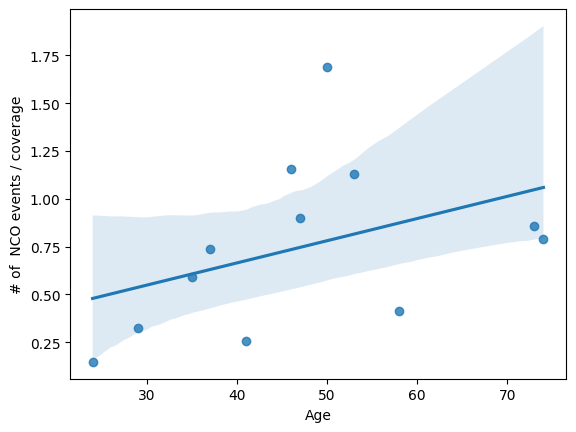

In [114]:
sns.regplot(
    x="sample_age",
    y="NCO_rate",
    data=xdf,
);

plt.xlabel("Age");
plt.ylabel("# of  NCO events / coverage");

In [33]:
import scipy.special

log_factorial = lambda n: scipy.special.gammaln(n+1)

In [48]:
def fit_poisson_constant(coverage, n_events):
    res = scipy.optimize.minimize_scalar(
        fun = lambda L: -(
            -(L * coverage).sum() 
            + (n_events * (np.log(L * coverage))).sum()
            - log_factorial(n_events).sum()        
        ),
        bounds = (0,10000),
    )
    return res.x, -res.fun

def fit_poisson_slope_no_intercept(age, coverage, n_events):
    res = scipy.optimize.minimize_scalar(
        fun = lambda L: -(
            -(L * coverage * age).sum() 
            + (n_events * (np.log(L * coverage * age))).sum()
            - log_factorial(n_events).sum()        
        ),
        bounds = (0,10000),
    )
    
    return res.x, -res.fun

In [50]:
fit_poisson_constant(xdf["coverage"], xdf["GC"])

(np.float64(0.8128994252555041), np.float64(-73.76331124080389))

In [51]:
fit_poisson_slope_no_intercept(xdf["sample_age"], xdf["coverage"], xdf["GC"])

(np.float64(0.01574210776593117), np.float64(-70.9384474054308))

In [63]:
fit_poisson_slope_no_intercept(np.random.permutation(xdf["sample_age"]), xdf["coverage"], xdf["GC"])

(np.float64(0.017985040390338835), np.float64(-82.96231196943734))

In [73]:
-70.9384474054308 - -73.76331124080389

2.824863835373094

In [121]:
def bootstrap_slope():
    age = np.random.choice(xdf["sample_age"], size=len(xdf), replace=True)
    
    slope_x, slope_LL = fit_poisson_slope_no_intercept(age, xdf["coverage"], xdf["GC"])
    
    return slope_x

In [ ]:
bslopes = [bootstrap_slope() for i in tqdm.trange(1000)]

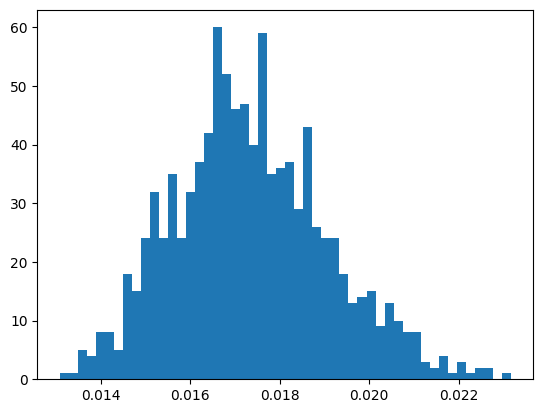

In [138]:
plt.hist(bslopes, bins=50);

In [130]:
np.quantile(a=bslopes, q=[2.5/100, 97.5/100])

array([0.01426687, 0.02102819])

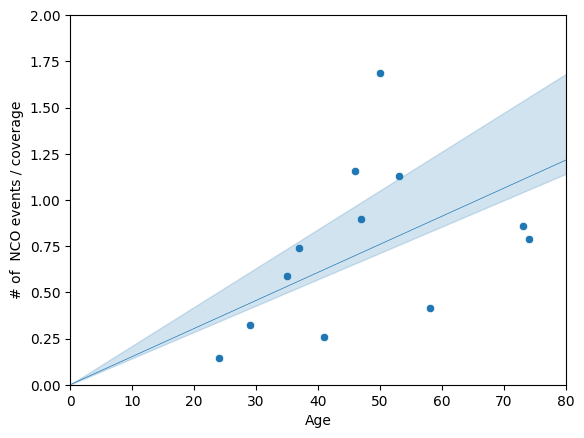

In [137]:
sns.scatterplot(
    x="sample_age",
    y="NCO_rate",
    data=xdf,
);

plt.xlabel("Age");
plt.ylabel("# of  NCO events / coverage");

plt.xlim(0, 80);
plt.ylim(0, 2);

plt.plot(
    [0, 80],
    [0, 80 * 0.0152],
    lw = 0.5,
);

plt.fill_between(
    x = [0, 80],
    y1 = [0, 80 * 0.01426687],
    y2 = [0, 80 * 0.02102819],
    color = "C0",
    alpha=0.2,
);

In [64]:
def random_dll():
    age = np.random.permutation(xdf["sample_age"])
    
    const_x, const_LL = fit_poisson_constant(xdf["coverage"], xdf["GC"])
    slope_x, slope_LL = fit_poisson_slope_no_intercept(age, xdf["coverage"], xdf["GC"])
    
    return slope_LL - const_LL
    #return res_double.x

In [67]:
random_dll()

np.float64(-15.333707833607491)

In [79]:
rdlls = [random_dll() for i in tqdm.trange(10000)]

100%|██████████| 10000/10000 [06:30<00:00, 25.62it/s]


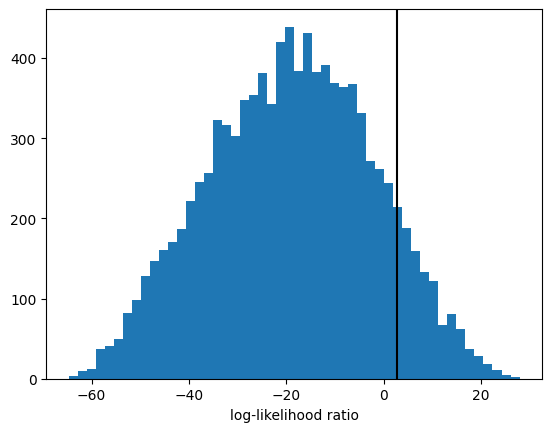

In [80]:
plt.hist(rdlls, bins=50);
plt.axvline(2.82, color="k");
plt.xlabel("log-likelihood ratio");

In [81]:
np.mean(np.array(rdlls) > 2.82)

np.float64(0.1036)

In [ ]:
scipy.stats.linregress(x = xdf["sample_age"], y = xdf["GC"])

In [ ]:
scipy.stats.linregress(x = xdf["sample_age"] * xdf["coverage"], y = xdf["GC"])

In [ ]:
scipy.stats.linregress(
    x =xdf["sample_age"], 
    y = xdf["GC"]/xdf["coverage"]) 

In [ ]:
linreses = [scipy.stats.linregress(
    x = np.random.permutation(xdf["sample_age"]), 
    y = xdf["GC"]/xdf["coverage"]) for i in tqdm.trange(10000)]

In [ ]:
(np.array([x.slope for x in linreses])>0.01).mean()

In [ ]:
plt.hist(np.array([x.slope for x in linreses]), bins=50);

In [ ]:
import sklearn.linear_model

In [ ]:
LR = sklearn.linear_model.LinearRegression(fit_intercept=False)

In [ ]:
# 0.01545677

In [ ]:
def randslope():
    return LR.fit(
        X = np.random.permutation(xdf["sample_age"].to_numpy()).reshape(-1, 1), 
        y = (xdf["GC"]/xdf["coverage"]).to_numpy(),
    ).coef_

In [ ]:
randslope()

### Make a dataframe of positions of all converted SNPs

In [32]:
NCO_df = candidates_df.filter(pl.col("high_quality_classification_class") == "GC")

In [33]:
%%time
converted_snps_df = (NCO_df
    .with_columns(
        (pl.col("idx_transitions").list.get(0)+1).alias("A"),
        (pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)).alias("B"),
    )
    .select(
        "sample_id",
        "chrom",
        "read_name",
        pl.col("snp_positions_on_read").list.slice(pl.col("A"), pl.col("B")).alias("start"),
        pl.col("AA_heat").is_not_null().alias("has_AA_DSB"),
    )
    .explode("start")
)

CPU times: user 46.8 ms, sys: 3.46 ms, total: 50.3 ms
Wall time: 25.7 ms


### Cross it with the sequences

In [ ]:
filenames = []
for R in rahbari_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )

for R in sudmant_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )

for R in ceph_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )
        
        
def F(filename):
    high_conf_snps_df = pl.scan_parquet(filename)
    
    df = (converted_snps_df
            .lazy()
            .join(
                (high_conf_snps_df
                    .select(
                        "read_name",
                        "start",
                        "refseq_start1",
                        "refseq_start2",    
                        "fits1_more",
                    )
                ),
                on=["read_name", "start"],
            )
        ).collect()
    
    return df

dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(filename) for filename in filenames
)
        
all_converted_snps_with_seq_df = pl.concat(dfs)

converted_snps_with_seq_df = all_converted_snps_with_seq_df.filter(
    (pl.col("refseq_start1").is_in(["G", "C"]) & pl.col("refseq_start2").is_in(["A", "T"])) |
    (pl.col("refseq_start2").is_in(["G", "C"]) & pl.col("refseq_start1").is_in(["A", "T"]))
)
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.7s


In [ ]:
read_to_converted_alleles_df = (all_converted_snps_with_seq_df
    .with_columns(
        original_allele = pl.when(pl.col("fits1_more") == 1).then("refseq_start2").otherwise("refseq_start1"),
        converted_allele = pl.when(pl.col("fits1_more") == 0).then("refseq_start2").otherwise("refseq_start1"),
    )
    .sort("read_name", "start")
    .group_by("read_name", maintain_order=True)
    .agg(    
        "original_allele", "converted_allele",
    ) 
)

# Save to xls file

In [31]:
xls_df = (candidates_df
    .rename({
        "high_quality_classification_class": "event_type",
        "mid_quality_snp_positions": "snp_positions",
        "mid_quality_snp_positions_alleles": "snp_alleles",
    })
    .join(
        pl.DataFrame({
            "sample_id": sample_id_to_paper_label.keys(),
            "label": sample_id_to_paper_label.values(),
        }),
        on="sample_id",
    )
    .join(
        read_to_converted_alleles_df,
        on="read_name",
        how="left",
    )
    .with_columns(
        dataset = (
            pl.when(pl.col("sample_id").is_in(rahbari_sample_ids))
            .then(pl.lit("TwinsUK"))
            .otherwise(
                pl.when(pl.col("sample_id").is_in(sudmant_sample_ids))
                .then(pl.lit("SL"))
                .otherwise(pl.lit("Platinum"))
            )
        ).cast(pl.Enum(["TwinsUK", "SL", "Platinum"])),
        chrom = pl.col("chrom").cast(pl.Enum(aut_chrom_names)),
        event_type = pl.col("event_type").replace(["GC", "CNCO"], ["NCO", "complex"]),
        genetic_length_in_cm = pl.col("full_read_crossover_prob") * 1e2,
        genetic_length_in_bp = pl.col("read_length"),
        gc_tract_lower_bound = (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1, null_on_oob=True)) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0, null_on_oob=True)+1)
        ),
        gc_tract_upper_bound = (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1, null_on_oob=True)+1) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0, null_on_oob=True))
        ),
        n_snps_converted = pl.col("idx_transitions").list.diff(null_behavior="drop").list.first(),     
    )
    .with_columns(
        (pl.col("genetic_length_in_cm")/(pl.col("genetic_length_in_bp")*1e-6)).alias("read_recomb_rate_in_cm_bp"),
    ) 
    .rename(
        {
            'AA_motif_center_pos': 'DSB_PRDM9_motif_center_pos',
            'AA_heat': 'DSB_PRDM9_heat',
            'AA_motif_strand': 'DSB_PRDM9_motif_strand',
        }
    )
    .sort(["dataset","label", "event_type", "chrom"])
    [[
        "dataset",
        "label", 
        "event_type",
        "chrom",
        "read_name",
        "read_length",
        "genetic_length_in_cm",
        "read_recomb_rate_in_cm_bp",
        "n_snps_converted",
        "gc_tract_lower_bound",
        "gc_tract_upper_bound",
        'grch37_reference_start',
        'grch38_reference_start',
        'T2T_reference_start',
        "snp_positions",
        "snp_alleles",
        "original_allele", 
        "converted_allele",
        'DSB_PRDM9_motif_center_pos',
        'DSB_PRDM9_heat',
        'DSB_PRDM9_motif_strand',
    ]]
    #.write_excel("/nfs/users/nfs_r/rs42/rs42/git/sperm/recombination_events.xlsx")
    #.write_parquet("/lustre/scratch122/tol/projects/sperm/results/recombination_events_sperm_20250325.parquet")
    #.write_excel("/lustre/scratch122/tol/projects/sperm/results/recombination_events_sperm_20250417.xlsx")
    #.write_parquet("/lustre/scratch122/tol/projects/sperm/results/recombination_events_sperm_20250417.parquet")
)

NameError: name 'read_to_converted_alleles_df' is not defined

In [30]:
call_stats_df = (candidates_df
    .with_columns(
        combined_class = pl.when(
            pl.col("high_quality_classification_class") == "CNCO"
        ).then(
            pl.lit("Complex")
        ).when(
            pl.col("high_quality_classification_in_detectable_class").is_not_null()
        ).then(
            "high_quality_classification_in_detectable_class"
        ).otherwise(
            pl.lit("Ambiguous")
        )
    )
    .pivot(
        values=["combined_class"],
        index=["sample_id"],
        columns=["combined_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "NCO", "Ambiguous", "Complex")
)

# call_stats_df = (
#     pl.DataFrame(
#         {
#             "sample_id": sample_presentation_order, 
#             "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
#         }
#     )
#     .join(call_stats_df, on="sample_id")
# )
with pl.Config(tbl_rows=40):
    display(call_stats_df)

/tmp/ipykernel_775971/976399186.py:15: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


sample_id,CO,NCO,Ambiguous,Complex
str,u32,u32,u32,u32
"""115980""",323,78,392,5
"""1894""",371,105,457,5
"""200100""",null,6,25,null
"""200101""",1,15,25,null
"""200102""",null,13,29,null
"""200104""",null,3,5,null
"""200106""",null,1,4,null
"""2895""",280,64,358,7
"""3898""",332,96,406,5
